In [1]:
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import category_encoders as ce
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split, RandomizedSearchCV, KFold
from sklearn.preprocessing import StandardScaler
import xgboost as xgb
from xgboost import XGBClassifier
from xgboost import plot_importance
%matplotlib inline 
pd.options.display.max_columns = None

X_train = pd.read_csv('DAT102x_Training_inputs.csv')
y_train = pd.read_csv("DAT102x_Training_labels.csv")
train = pd.concat([X_train, y_train], axis=1)

In [2]:
train.count()

row_id                            500000
loan_type                         500000
property_type                     500000
loan_purpose                      500000
occupancy                         500000
loan_amount                       500000
preapproval                       500000
msa_md                            500000
state_code                        500000
county_code                       500000
applicant_ethnicity               500000
applicant_race                    500000
applicant_sex                     500000
applicant_income                  460052
population                        477535
minority_population_pct           477534
ffiecmedian_family_income         477560
tract_to_msa_md_income_pct        477486
number_of_owner-occupied_units    477435
number_of_1_to_4_family_units     477470
lender                            500000
co_applicant                      500000
row_id                            500000
accepted                          500000
dtype: int64

In [3]:
train.drop("row_id", axis=1, inplace=True)

replace_dict = {
    'msa_md': -1,
    'state_code': -1,
    'county_code': -1,
    'occupancy': 3,
    'preapproval': 3,
    'applicant_ethnicity': [3, 4, 5],
    "applicant_race": [6, 7, 8],
    "applicant_sex": [3, 4, 5]
}

cat_cols_few = ["loan_type", "property_type", "loan_purpose", "occupancy", "preapproval",
                "applicant_ethnicity", "applicant_race", "applicant_sex", "co_applicant"] 

cat_cols_many = ["msa_md", "state_code", "county_code", "lender"]

numerical_cols = ["loan_amount", "applicant_income", "population", "minority_population_pct",
                 "ffiecmedian_family_income", "tract_to_msa_md_income_pct",
                 "number_of_owner-occupied_units", "number_of_1_to_4_family_units"]

train.replace(replace_dict, np.nan, inplace = True)
train.count()

loan_type                         500000
property_type                     500000
loan_purpose                      500000
occupancy                         497811
loan_amount                       500000
preapproval                        88891
msa_md                            423018
state_code                        480868
county_code                       479534
applicant_ethnicity               436883
applicant_race                    434460
applicant_sex                     458682
applicant_income                  460052
population                        477535
minority_population_pct           477534
ffiecmedian_family_income         477560
tract_to_msa_md_income_pct        477486
number_of_owner-occupied_units    477435
number_of_1_to_4_family_units     477470
lender                            500000
co_applicant                      500000
accepted                          500000
dtype: int64

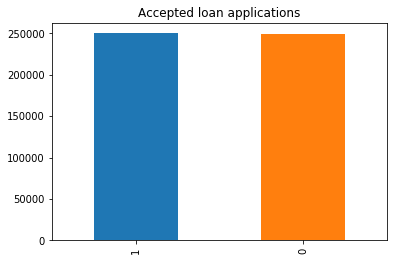

1    0.500228
0    0.499772
Name: accepted, dtype: float64

In [4]:
train["accepted"].value_counts().plot(kind='bar')
plt.title('Accepted loan applications')
plt.show()
train["accepted"].value_counts(normalize = 'index')

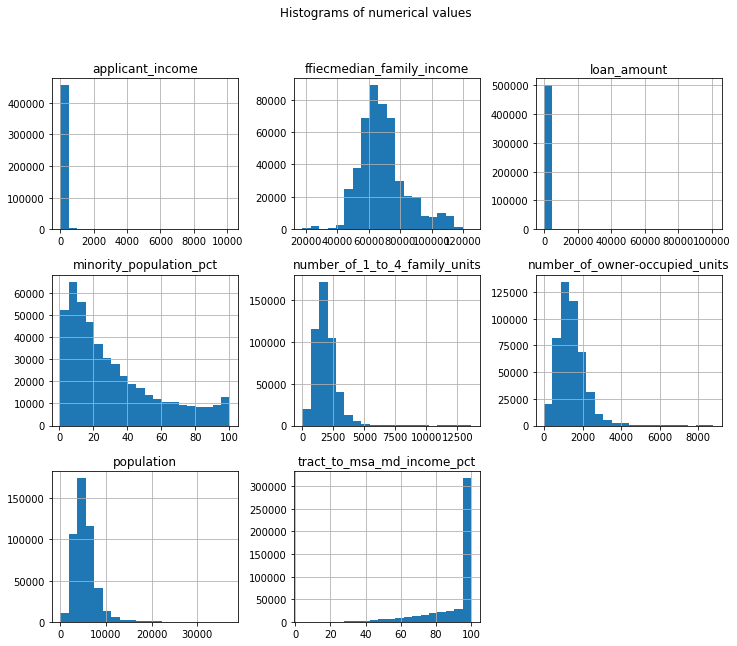

Skewness of numerical columns:


loan_amount                       76.552786
applicant_income                  22.277181
population                         2.864237
minority_population_pct            1.009139
ffiecmedian_family_income          0.773280
tract_to_msa_md_income_pct        -1.963872
number_of_owner-occupied_units     1.881743
number_of_1_to_4_family_units      2.016264
dtype: float64

In [5]:
train[numerical_cols].hist(figsize=(12,10), bins=20)
plt.suptitle("Histograms of numerical values")
plt.show()

print("Skewness of numerical columns:")
train[numerical_cols].skew()

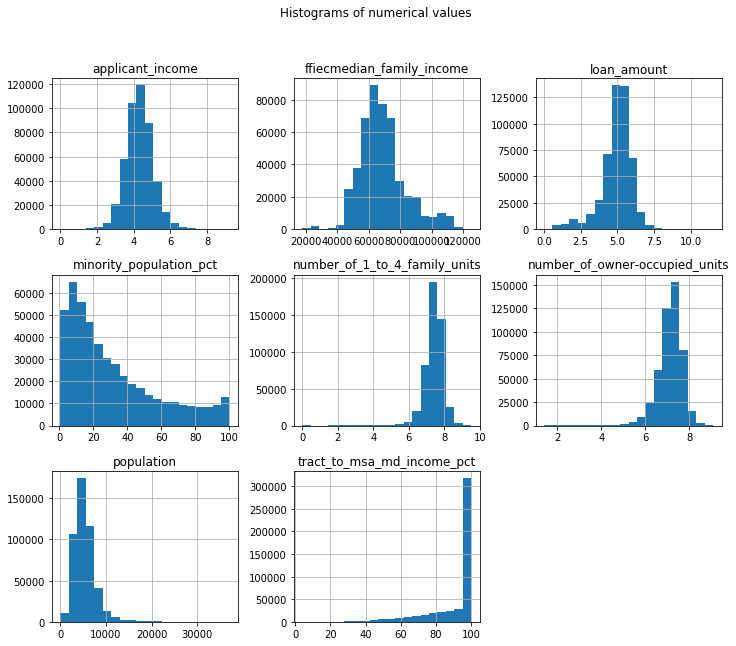

Skewness of numerical columns after applying log function:


loan_amount                      -1.190548
applicant_income                  0.026275
population                        2.864237
minority_population_pct           1.009139
ffiecmedian_family_income         0.773280
tract_to_msa_md_income_pct       -1.963872
number_of_owner-occupied_units   -1.076900
number_of_1_to_4_family_units    -1.568488
dtype: float64

In [6]:
import math
to_log = ["loan_amount", "applicant_income", "number_of_owner-occupied_units", "number_of_1_to_4_family_units"]
train[to_log] = train[to_log].applymap(math.log)

train[numerical_cols].hist(figsize=(12,10), bins=20)
plt.suptitle("Histograms of numerical values")
plt.show()

print("Skewness of numerical columns after applying log function:")
train[numerical_cols].skew()

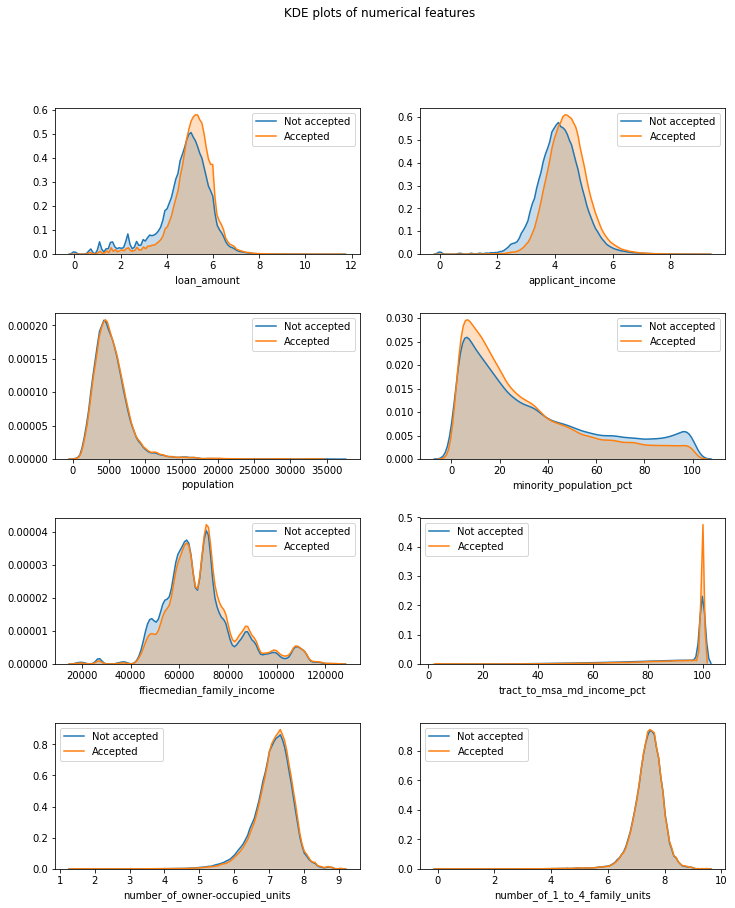

In [7]:
import warnings
warnings.filterwarnings("ignore")

fig, axes = plt.subplots(ncols = 2, nrows = 4, figsize = (12,14))
fig.subplots_adjust(hspace = 0.4, wspace = 0.2)
fig.suptitle("KDE plots of numerical features")

for ax, col in zip(axes.flatten(), numerical_cols) :
    sns.kdeplot(train[train["accepted"] == 0][col], shade="True", label="Not accepted", ax = ax)
    sns.kdeplot(train[train["accepted"] == 1][col], shade="True", label="Accepted", ax = ax)
    ax.set_xlabel(col)

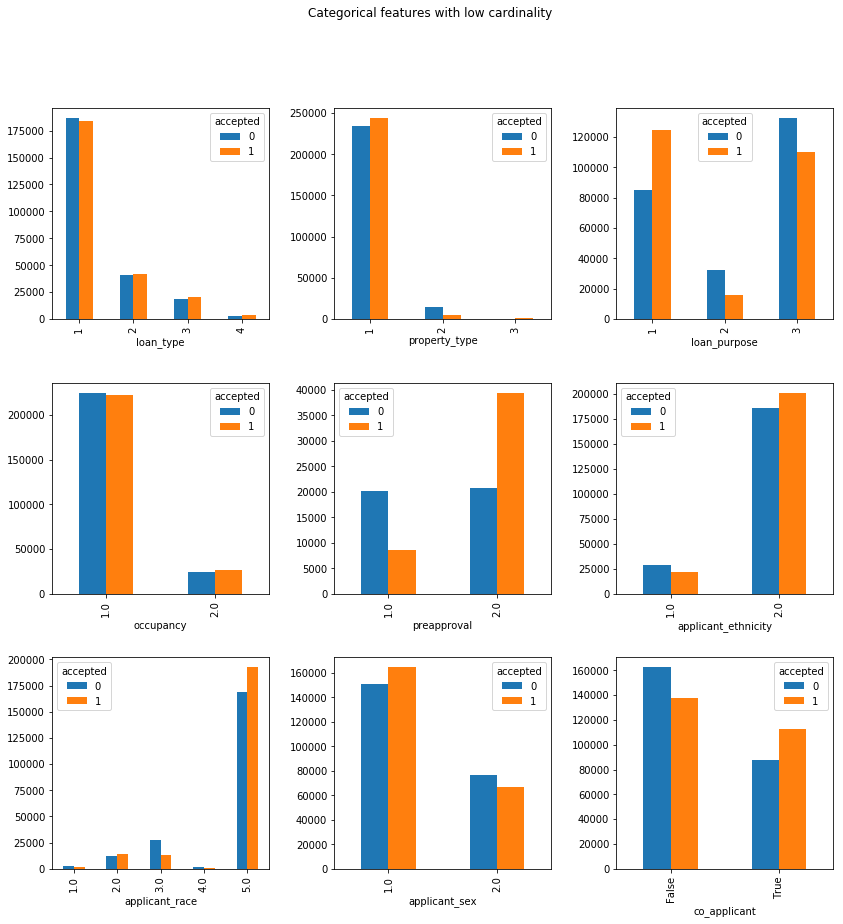

In [8]:
fig, axes = plt.subplots(ncols = 3, nrows = 3, figsize = (14,14))
fig.subplots_adjust(hspace = 0.3, wspace = 0.3)
fig.suptitle("Categorical features with low cardinality")

for ax, col in zip(axes.flatten(), cat_cols_few) :
    pd.crosstab(train[col], train["accepted"]).plot(kind="bar", ax = ax)
    ax.set_xlabel(col)

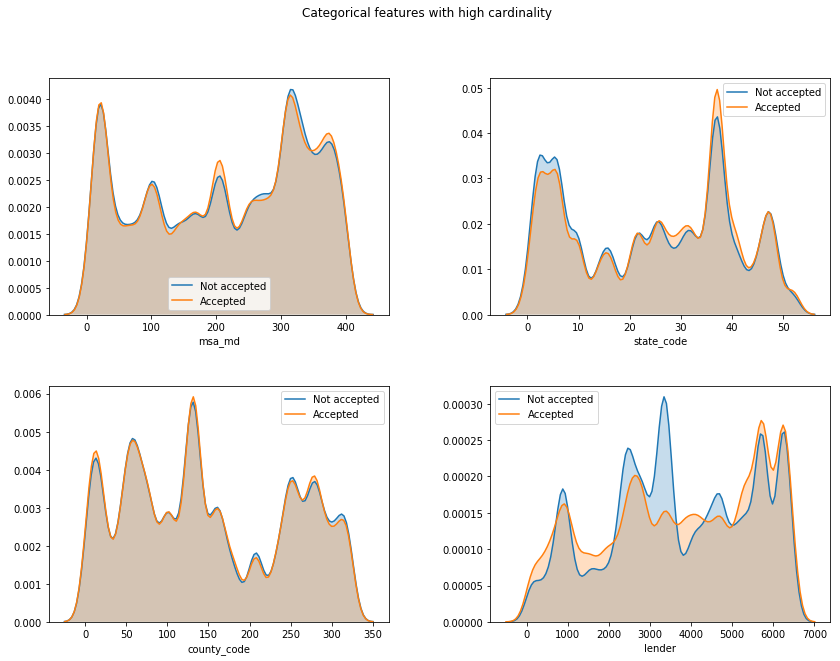

In [9]:
fig, axes = plt.subplots(ncols = 2, nrows = 2, figsize = (14,10))
fig.subplots_adjust(hspace = 0.3, wspace = 0.3)
fig.suptitle("Categorical features with high cardinality")

for ax, col in zip(axes.flatten(), cat_cols_many) :
    sns.kdeplot(train[train["accepted"] == 0][col], shade="True", label="Not accepted", ax = ax)
    sns.kdeplot(train[train["accepted"] == 1][col], shade="True", label="Accepted", ax = ax)
    ax.set_xlabel(col)

In [10]:
train["minority_population"] = (train["minority_population_pct"] / 100) * (train["population"])
train["tract_family_income"] = (train["tract_to_msa_md_income_pct"] /100) * (train["ffiecmedian_family_income"])

train["minority_population"] = train["minority_population"].apply(math.log)

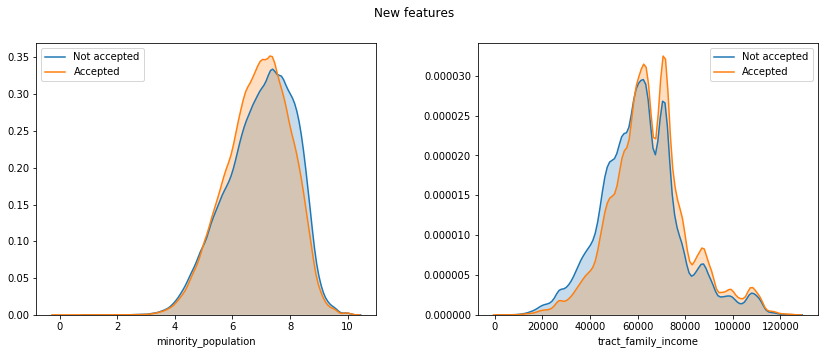

In [11]:
new_cols = ["minority_population", "tract_family_income"]

fig, axes = plt.subplots(ncols = 2, nrows = 1, figsize = (14,5))
fig.subplots_adjust(hspace = 0.5, wspace = 0.3)
fig.suptitle("New features")

for ax, col in zip(axes.flatten(), new_cols) :
    sns.kdeplot(train[train["accepted"] == 0][col], shade="True", label="Not accepted", ax = ax)
    sns.kdeplot(train[train["accepted"] == 1][col], shade="True", label="Accepted", ax = ax)
    ax.set_xlabel(col)

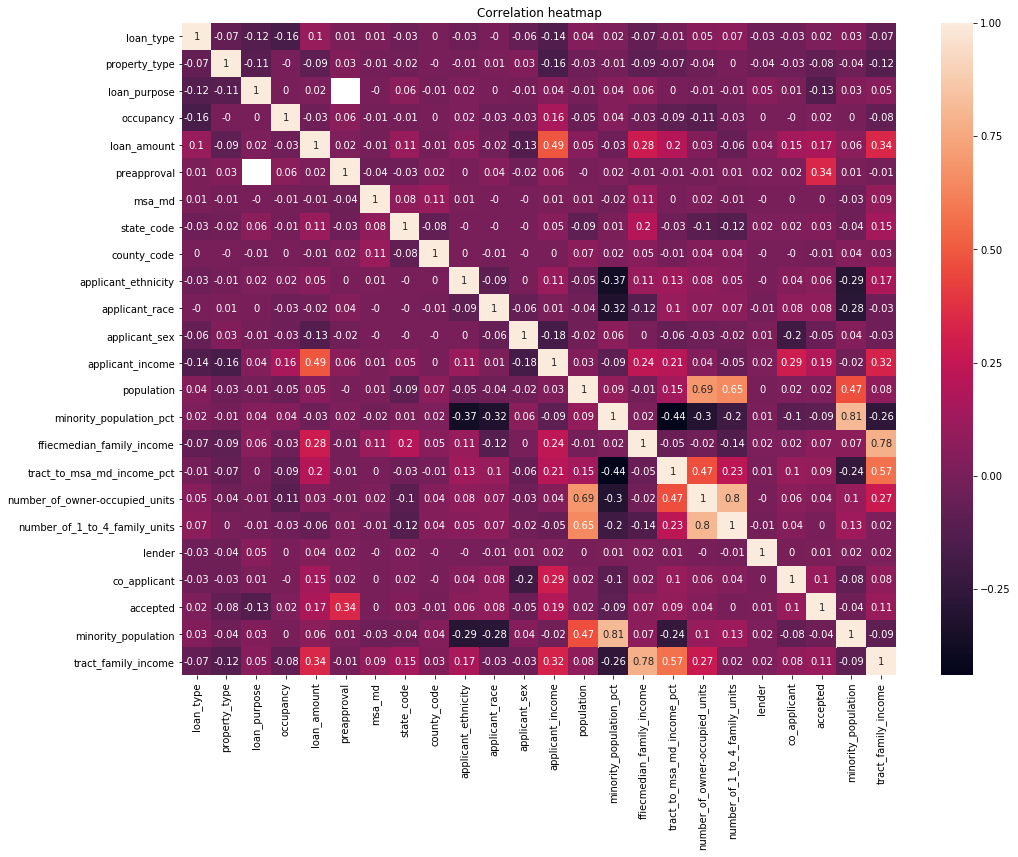

In [12]:
plt.figure(figsize=(16,12))
sns.heatmap(train.corr().round(decimals=2), annot=True)
plt.title("Correlation heatmap")
plt.show()

In [13]:
to_log = ["loan_amount", "applicant_income", "number_of_owner-occupied_units",
          "number_of_1_to_4_family_units", "minority_population"]

to_drop = ["row_id", "number_of_1_to_4_family_units",
           "occupancy", "preapproval", "county_code"]

num_cols = ["loan_amount", "applicant_income", "population", "minority_population_pct",
            "ffiecmedian_family_income", "tract_to_msa_md_income_pct",
            "number_of_owner-occupied_units"]

cat_cols_few = ["loan_type", "property_type", "loan_purpose",
            "applicant_ethnicity", "applicant_race",
            "applicant_sex", "co_applicant"]

def prepare_data(df):
    
    df["co_applicant"] = df["co_applicant"].astype("int8")
    df.replace(replace_dict, np.nan, inplace = True)
    
    for col in num_cols:
        df[col].fillna(df[col].median(), inplace=True)
        
    for col in cat_cols_few:
        df[col].fillna(df[col].mode()[0], inplace=True)
        
    df["minority_population"] = (df["minority_population_pct"] / 100) * (df["population"])
    df["tract_family_income"] = (df["tract_to_msa_md_income_pct"] / 100) * (df["ffiecmedian_family_income"])

    df[to_log] = df[to_log].applymap(math.log)
    
    to_drop.extend(["minority_population_pct", "population",
                    "ffiecmedian_family_income", "tract_to_msa_md_income_pct"])
    df.drop(to_drop, axis=1, inplace=True)
    
    df = pd.get_dummies(df, columns = cat_cols_few)
    
    return df


In [14]:
train.head()

,loan_type,property_type,loan_purpose,occupancy,loan_amount,preapproval,msa_md,state_code,county_code,applicant_ethnicity,applicant_race,applicant_sex,applicant_income,population,minority_population_pct,ffiecmedian_family_income,tract_to_msa_md_income_pct,number_of_owner-occupied_units,number_of_1_to_4_family_units,lender,co_applicant,accepted,minority_population,tract_family_income
0,3,1,1,1.0,4.248495,NaN,18.0,37.0,246.0,2.0,5.0,1.0,3.178054,6203.0,44.230,60588.0,50.933,6.573680,7.879291,4536,False,1,7.917021,30859.28604
1,1,1,3,1.0,5.181784,NaN,369.0,52.0,299.0,1.0,5.0,1.0,4.043051,5774.0,15.905,54821.0,100.000,7.391415,7.653495,2458,False,0,6.822584,54821.00000
2,2,1,3,1.0,5.093750,NaN,16.0,10.0,306.0,2.0,5.0,1.0,4.204693,6094.0,61.270,67719.0,100.000,6.633318,6.954639,5710,False,1,8.225180,67719.00000
3,1,1,1,1.0,5.043425,1.0,305.0,47.0,180.0,2.0,5.0,1.0,4.653960,6667.0,6.246,78439.0,100.000,7.613325,7.740230,5888,True,1,6.031696,78439.00000
4,1,1,1,1.0,5.720312,NaN,24.0,37.0,20.0,2.0,3.0,2.0,4.262680,6732.0,100.000,63075.0,82.200,7.288928,7.521318,289,False,1,8.814628,51847.65000


In [15]:
X_train = prepare_data(X_train)

ce_target = ce.TargetEncoder(cols = ["lender", "msa_md", "state_code"], smoothing = 5, return_df = True)
X_train = ce_target.fit_transform(X_train, y_train["accepted"])

In [16]:
X_train, X_test, y_train, y_test = train_test_split(X_train.values, y_train["accepted"].values, test_size=0.3, random_state=0)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [17]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import numpy.random as nr
import math
from sklearn import preprocessing
import sklearn.model_selection as ms
from sklearn import linear_model
import sklearn.metrics as sklm
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from scipy.io import arff
import pandas as pd
#from sklearn import cross_validation
import xgboost
import xgboost as xgb

In [19]:
model = XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.6, gamma=0, learning_rate=0.02, max_delta_step=0,
       max_depth=8, min_child_weight=8, missing=None, n_estimators=600,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0.2, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=0.7)

model.fit(X_train, y_train)


y_pred = model.predict(X_test)
prediction = [round(value) for value in y_pred]

accuracy = accuracy_score(y_test, prediction)
print("Accuracy: %.2f%%" % (accuracy * 100.0))



Accuracy: 72.59%


The accuracy is: 0.72592


Classification Report:
              precision    recall  f1-score   support

           0       0.75      0.68      0.71     74876
           1       0.71      0.78      0.74     75124

    accuracy                           0.73    150000
   macro avg       0.73      0.73      0.73    150000
weighted avg       0.73      0.73      0.73    150000



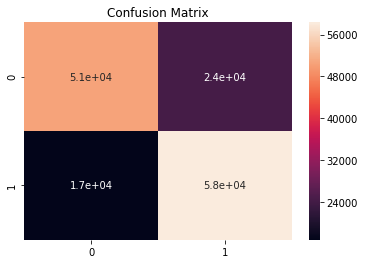

In [20]:
prediction = [round(value) for value in y_pred]
print('The accuracy is:', metrics.accuracy_score(y_test, prediction))
print("\n")
print("Classification Report:")
print(metrics.classification_report(y_test, prediction))

sns.heatmap(confusion_matrix(y_test, prediction), annot=True)
plt.title("Confusion Matrix")
plt.show()

In [21]:
# Preparing the test data set

In [22]:
test = pd.read_csv('DAT102x_Predicting_Test_values.csv')

In [23]:
test.population.describe()

count    477520.000000
mean       5411.205196
std        2719.506721
min           1.000000
25%        3746.000000
50%        4975.000000
75%        6455.000000
max       34194.000000
Name: population, dtype: float64

test.drop("row_id", axis=1, inplace=True)

replace_dict2 = {
    'msa_md': -1,
    'state_code': -1,
    'county_code': -1,
    'occupancy': 3,
    'preapproval': 3,
    'applicant_ethnicity': [3, 4, 5],
    "applicant_race": [6, 7, 8],
    "applicant_sex": [3, 4, 5]
}

cat_cols_main = ["loan_type", "property_type", "loan_purpose", "occupancy", "preapproval",
                "applicant_ethnicity", "applicant_race", "applicant_sex", "co_applicant"] 

cat_cols_add = ["msa_md", "state_code", "county_code", "lender"]

numerical_cols2 = ["loan_amount", "applicant_income", "population", "minority_population_pct",
                 "ffiecmedian_family_income", "tract_to_msa_md_income_pct",
                 "number_of_owner-occupied_units", "number_of_1_to_4_family_units"]

test.replace(replace_dict2, np.nan, inplace = True)
test.count()

In [24]:
prepared_test = prepare_data(test)


In [25]:
final_test = ce_target.transform(prepared_test)

In [26]:
train.columns

Index(['loan_type', 'property_type', 'loan_purpose', 'occupancy',
       'loan_amount', 'preapproval', 'msa_md', 'state_code', 'county_code',
       'applicant_ethnicity', 'applicant_race', 'applicant_sex',
       'applicant_income', 'population', 'minority_population_pct',
       'ffiecmedian_family_income', 'tract_to_msa_md_income_pct',
       'number_of_owner-occupied_units', 'number_of_1_to_4_family_units',
       'lender', 'co_applicant', 'accepted', 'minority_population',
       'tract_family_income'],
      dtype='object')

In [27]:
test.columns

Index(['loan_type', 'property_type', 'loan_purpose', 'loan_amount', 'msa_md',
       'state_code', 'applicant_ethnicity', 'applicant_race', 'applicant_sex',
       'applicant_income', 'number_of_owner-occupied_units', 'lender',
       'co_applicant', 'minority_population', 'tract_family_income'],
      dtype='object')

In [30]:
topredict = scaler.transform(final_test)

In [31]:
test_predictions = model.predict(topredict)

In [32]:
submission = pd.read_csv('DAT102x_Submission_format.csv')

In [34]:
submission['accepted']=test_predictions

In [35]:
submission.to_csv('submission_tam.csv', index=False, header= True)